# End-to-End Lane Navigation via Nvidia Model
Author: Soumya Ranjan Choudhury

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
model_output_dir = '/content/gdrive/MyDrive/Cloning/LaneModel'

Mounted at /content/gdrive


In [22]:
#################### SEND ALERT EMAIL AT FINISH WITH GMAIL #####################
# To send email from Python from your google account, MUST 
# 1) Enable less secure app
# https://myaccount.google.com/lesssecureapps
# 2) Disable Unlock Capcha
# https://accounts.google.com/b/0/DisplayUnlockCaptcha

import smtplib

def SendEmail(msg):
    # store gmail password in my google drive (not the most secure way)
    # but it is much safer than storing it directly in this notebook, 
    # and upload it to github for everyone to see
    with open('/content/gdrive/MyDrive/Cloning/pw.txt') as file:
        data = file.readlines()
        
    gmail_user = 'somchoudhury69@gmail.com'  
    gmail_password = data[0]

    sent_from = gmail_user  
    to = ['soumyaranjanchoudhury194@gmail.com']  
    subject = msg  
    body = '%s\n\n- Soumya' % msg

    email_text = \
"""From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.ehlo()
    server.starttls()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, email_text)
    server.quit()

    print(f'Email: \n{email_text}')

## Imports Packages

In [3]:
!pip install tensorflow==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 1.1 MB/s 
     |████████████████████████████████| 3.2 MB 42.4 MB/s 
     |████████████████████████████████| 50 kB 9.6 MB/s 
     |████████████████████████████████| 367 kB 82.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [4]:
!pip install keras==2.2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 312 kB 15.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


In [5]:
import os
import pickle
import random
import fnmatch
import datetime

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from imgaug import augmenters as img_aug

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

tf.__version__: 1.13.1
keras.__version__: 2.2.4


## Load Train Data

image_path: /content/gdrive/MyDrive/Cloning/data/images/video01_032_049.png
steering_Angle: 49


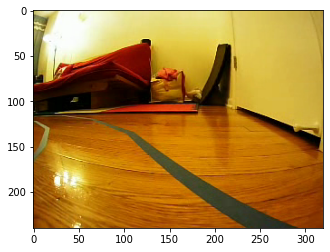

In [6]:
data_dir = '/content/gdrive/MyDrive/Cloning/data/images'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([1.0000, 1.0000, 8.0000, 4.0000, 5.0000, 11.0000, 6.0000, 7.0000,
        26.0000, 2.0000, 10.0000, 21.0000, 18.0000, 23.0000, 15.0000,
        21.0000, 12.0000, 10.0000, 2.0000, 5.0000, 2.0000, 1.0000, 3.0000,
        2.0000, 3.0000]),
 array([44.0000, 46.3600, 48.7200, 51.0800, 53.4400, 55.8000, 58.1600,
        60.5200, 62.8800, 65.2400, 67.6000, 69.9600, 72.3200, 74.6800,
        77.0400, 79.4000, 81.7600, 84.1200, 86.4800, 88.8400, 91.2000,
        93.5600, 95.9200, 98.2800, 100.6400, 103.0000]),
 <a list of 25 Patch objects>)

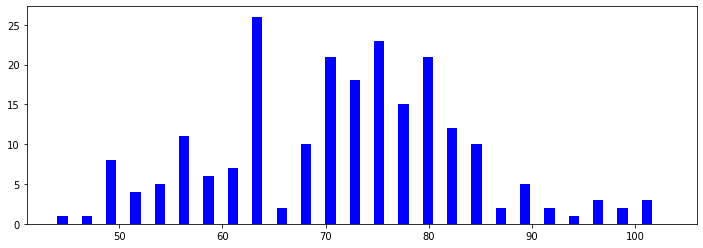

In [7]:
# Check the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Notice that the above diagram contains angeles mostly smaller than 90.  This makes sense, because in our training data, The car was mostly turning left.  This is going to fine, because we will balance the data by randomly flip the image, and the steering angle in the image generator process.

Training data: 175
Validation data: 44


Text(0.5, 1.0, 'Validation Data')

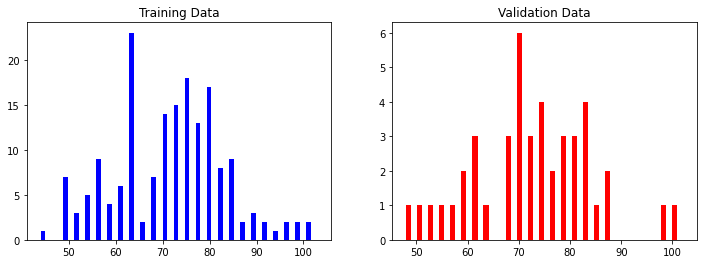

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

##Image Augumentation
Since we only have a few hundred images, to train a deep network, we need a lot more images.   Instead of running our car, let's try to augment our data. There are a couple of ways to do that.

1. Zoom: crop out a smaller image from the center
1. Pan: crop out a smaller image from left or right side
1. adjust brightness of the image
1. flip the image horizontally, i.e do a left to right flip, and change the steering angle coorespondingly
1. introduce an Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.



Text(0.5, 1.0, 'zoomed')

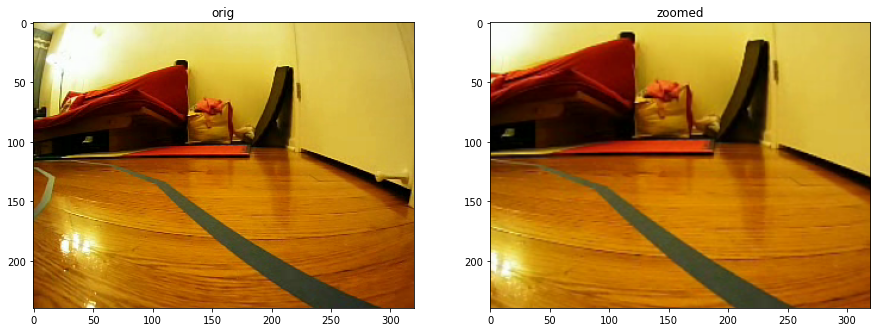

In [9]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")

Text(0.5, 1.0, 'panned')

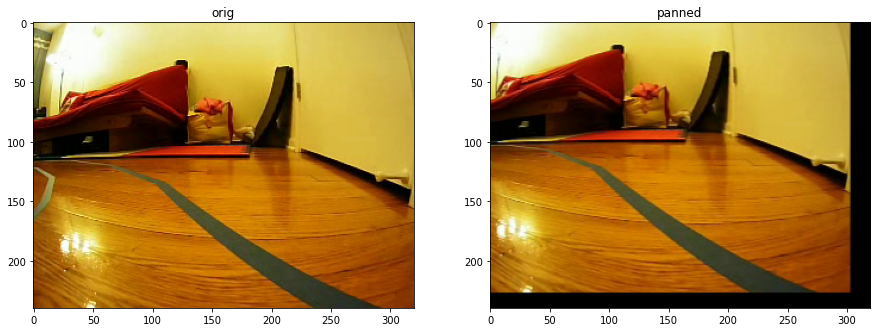

In [10]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")

Text(0.5, 1.0, 'brightness adjusted')

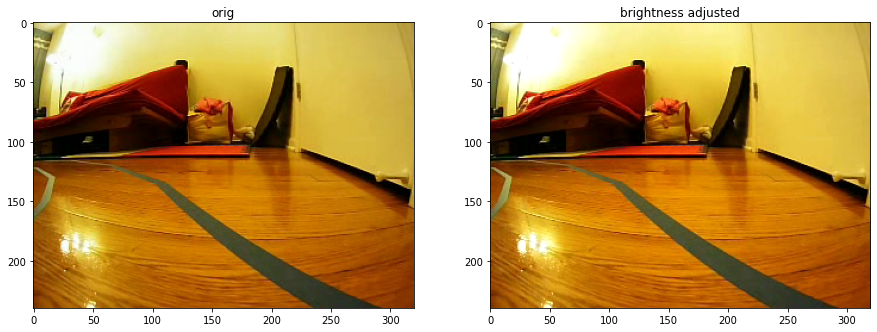

In [11]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

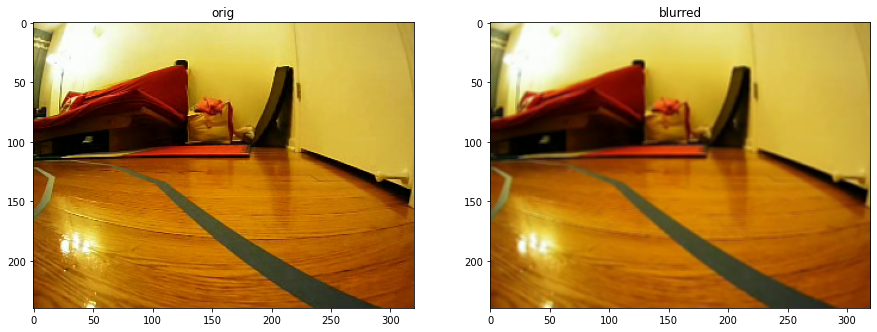

In [12]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=49')

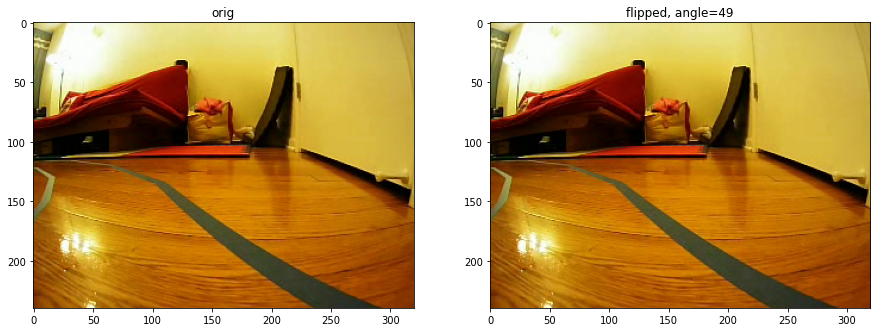

In [13]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

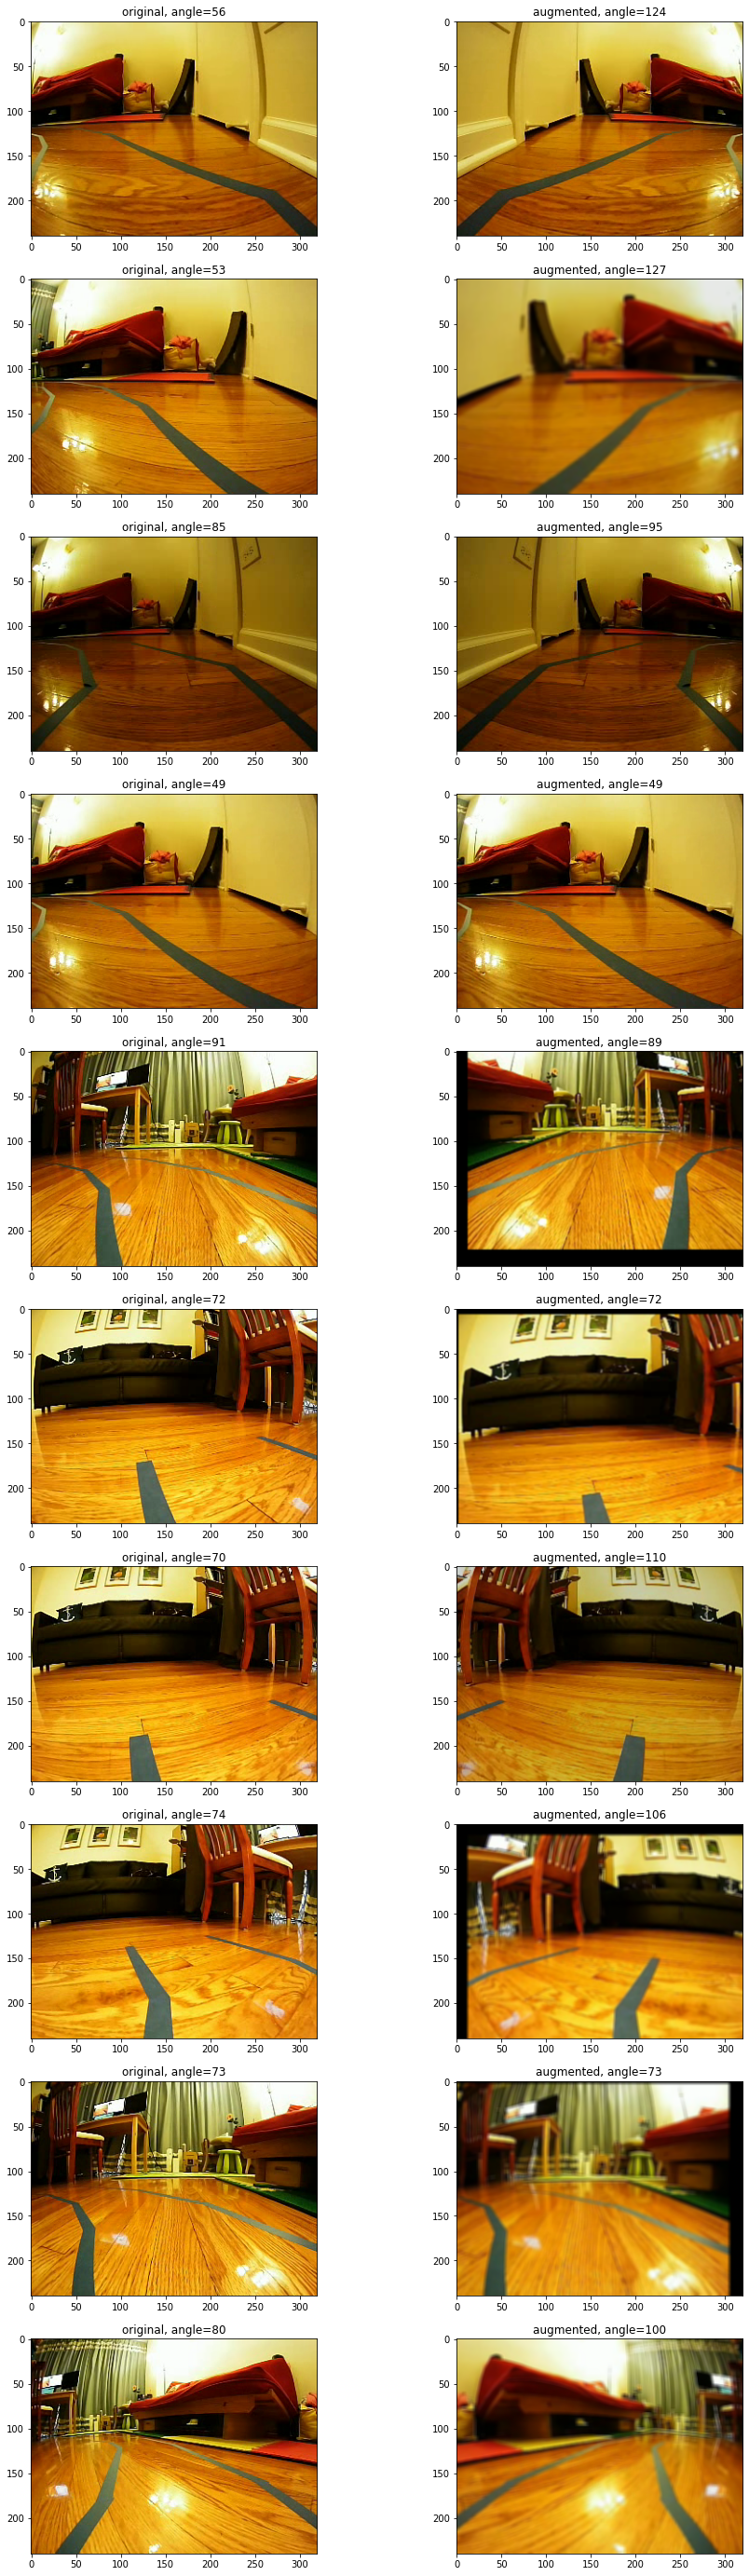

In [14]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)

## Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

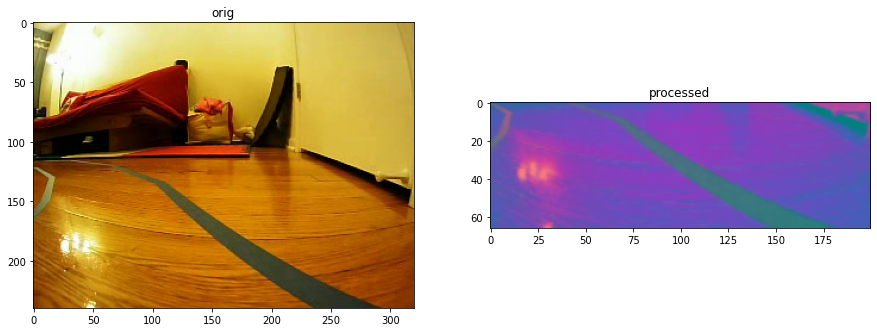

In [15]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

## Create and Train Model

This is the Nvidia CNN Model Architecture. The input layer is at the bottom with size of 200x66 in YUV color space ![](https://github.com/dctian/DeepPiCar/raw/master/models/lane_navigation/doc/NVidia%20Model%20Architecture.JPG) .



In [16]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [17]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [18]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))   

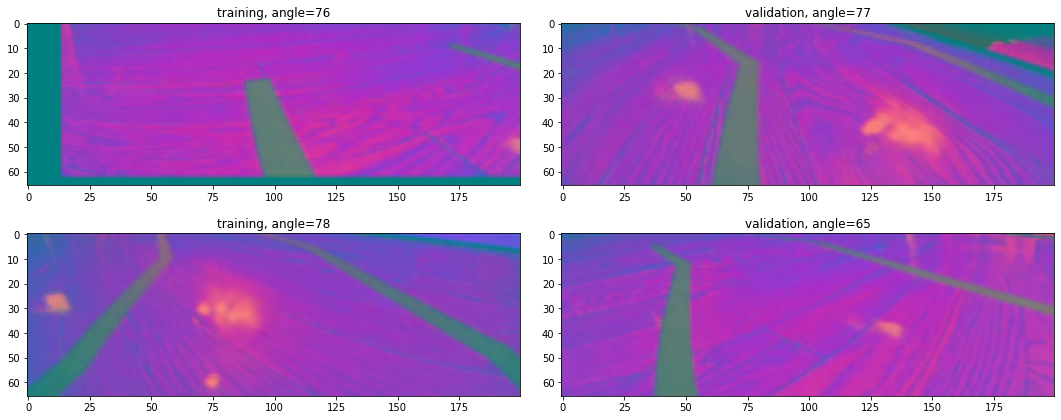

In [19]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [20]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root

In [ ]:
# this block prevents the training from starting if we Run All
DO_NOT_RUN_ALL

In [24]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

# SendEmail("lane nav train started")
history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    
# SendEmail("lane nav train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))


Instructions for updating:
Use tf.cast instead.


Epoch 1/10
300/300 [==============================] - 428s 1s/step - loss: 703.1467 - val_loss: 303.2631

Epoch 00001: val_loss improved from inf to 303.26307, saving model to /content/gdrive/MyDrive/Cloning/LaneModel/lane_navigation_check.h5
Epoch 2/10
300/300 [==============================] - 416s 1s/step - loss: 467.6907 - val_loss: 406.4870

Epoch 00002: val_loss did not improve from 303.26307
Epoch 3/10
300/300 [==============================] - 420s 1s/step - loss: 468.5473 - val_loss: 429.9249

Epoch 00003: val_loss did not improve from 303.26307
Epoch 4/10
300/300 [==============================] - 424s 1s/step - loss: 433.6849 - val_loss: 142.6973

Epoch 00004: val_loss improved from 303.26307 to 142.69728, saving model to /content/gdrive/MyDrive/Cloning/LaneModel/lane_navigation_check.h5
Epoch 5/10
300/300 [==============================] - 429s 1s/step - loss: 108.3850 - val_loss: 38.8754

Epoch 00005: val_loss improved from 142.69728 to 38.87538, saving model to /content/g

## Check Trained Model on Validation Data

In [25]:
history.history

{'val_loss': [303.2630704498291,
  406.4869877624512,
  429.92490142822265,
  142.6972847747803,
  38.87538385391235,
  27.89944080352783,
  22.259048843383788,
  24.010706543922424,
  17.676778984069824,
  15.921070437431336],
 'loss': [703.1466717529297,
  467.69074849446616,
  468.54727752685545,
  433.68494623819987,
  108.38500845591227,
  39.59361789703369,
  25.71593139966329,
  20.339368263880413,
  17.378819224039713,
  15.662170632680256]}

In [26]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

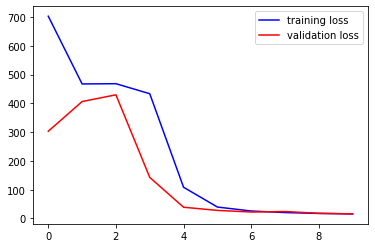

In [27]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    # model = load_model('lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

mse       = 1.4e+01
r_squared = 88.64%



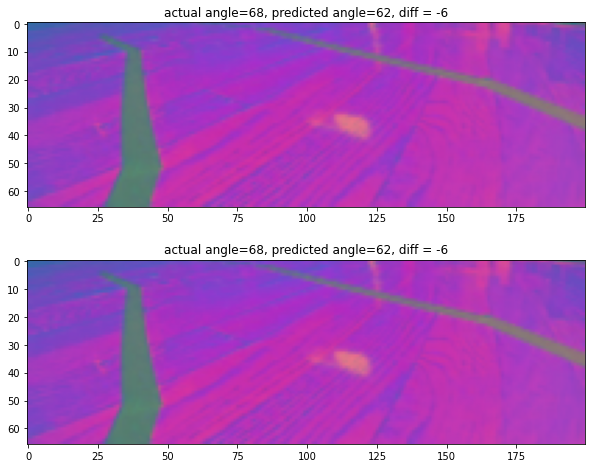

In [36]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")

As we can see the $R^2$ of the predicted was around 95% and Mean Squared Errors (MSE) are low, indicating the model is predicting a steering angle every simliar to our hand coded land follower, which was used as the model input. 

## References
1. Mariusz Bojarski, Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel, Mathew Monfort, Urs Muller, Jiakai Zhang, Xin Zhang, Jake Zhao, Karol Zieba (2016) *End to End Learning for Self-Driving Cars*. Nvidia 
1. Keras Documentation (2019) https://github.com/keras-team/keras/

